### Connecting Python with SQLite - Balazs Balogh - 2019-10-29

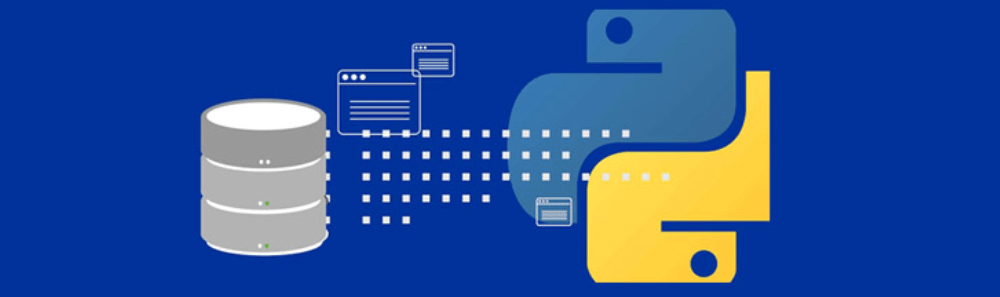

In [1]:
"""
This notebook is an example of using SQLite with Python, and making a visualisation from the data we have.
"SQLite is the most used database engine in the world."
To install open the Anaconda Prompt and use the "conda install -c blaze sqlite3" command.
"""

import pandas as pd
import sqlite3

stops_orig = pd.read_csv('https://raw.githubusercontent.com/budapestpy-workshops/sample_files/master/stops.txt')
stops_orig.head()

,stop_id,stop_name,stop_lat,stop_lon,stop_code,location_type,parent_station,wheelchair_boarding,stop_direction
0,002133,"Örs vezér tere M+H, déli tárolótér",47.500366,19.135700,NaN,NaN,NaN,NaN,NaN
1,002136,Fogas üzem (kapu),47.509119,19.014403,NaN,NaN,NaN,NaN,NaN
2,002138,Kőbánya alsó vasútállomás,47.483139,19.127891,NaN,NaN,NaN,2.0,NaN
3,003002,Puskás Ferenc Stadion M,47.500368,19.103406,NaN,NaN,NaN,NaN,NaN
4,003103,"Káposztásmegyer, Mogyoródi-patak",47.598778,19.121447,NaN,NaN,NaN,NaN,NaN


In [2]:
"""
First check out the DataFrame. We need the first four columns for this project, and fortunately they don't have any NaN values,
so we don't have to delete, or fill any values.
"""

stops_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5940 entries, 0 to 5939
Data columns (total 9 columns):
stop_id                5940 non-null object
stop_name              5940 non-null object
stop_lat               5940 non-null float64
stop_lon               5940 non-null float64
stop_code              557 non-null object
location_type          310 non-null float64
parent_station         437 non-null object
wheelchair_boarding    5763 non-null float64
stop_direction         5047 non-null float64
dtypes: float64(5), object(4)
memory usage: 417.8+ KB


In [3]:
stops_orig.tail()

,stop_id,stop_name,stop_lat,stop_lon,stop_code,location_type,parent_station,wheelchair_boarding,stop_direction
5935,LMXKPJ,Keleti pályaudvar [J],47.500166,19.081876,LMXKPJ,2.0,CSLMXKPB,2.0,NaN
5936,LMXKPK,Keleti pályaudvar [K],47.499635,19.080700,LMXKPK,2.0,CSLMXKPB,1.0,NaN
5937,LMXKPL,Keleti pályaudvar [L],47.499448,19.080676,LMXKPL,2.0,CSLMXKPB,2.0,NaN
5938,LMXKPM,Keleti pályaudvar [M],47.499376,19.080515,LMXKPM,2.0,CSLMXKPB,2.0,NaN
5939,LMXKPN,Keleti pályaudvar [N],47.499887,19.079791,LMXKPN,2.0,CSLMXKPB,2.0,NaN


In [4]:
"""
Let's make a new df from the columns we are interested in.
"""

stops = stops_orig[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]
stops.head()

,stop_id,stop_name,stop_lat,stop_lon
0,002133,"Örs vezér tere M+H, déli tárolótér",47.500366,19.135700
1,002136,Fogas üzem (kapu),47.509119,19.014403
2,002138,Kőbánya alsó vasútállomás,47.483139,19.127891
3,003002,Puskás Ferenc Stadion M,47.500368,19.103406
4,003103,"Káposztásmegyer, Mogyoródi-patak",47.598778,19.121447


In [5]:
"""
When we design a database, it's useful to know, how long is the longest string in the column, because we can choose the right
datatype. In our case, 40 characters is the longest name of the stops, so we could choose varchar(50) for puffer for future
values, or higher. The point is that no need for varchar(max) or even varchar(255). 

If you're interested more in this topic, read this answer:
https://dba.stackexchange.com/questions/162113/would-using-varchar5000-be-bad-compared-to-varchar255

Homework: Write a function called varchar_max, which iterates through the columns which are object datatype, checks the maximum
value, give it a 20% puffer, and print it out like this: "stop_name - varchar(48)".
"""

stops['stop_name'].map(len).max()

40

In [6]:
stops.values.tolist()

[['002133', 'Örs vezér tere M+H, déli tárolótér', 47.500366, 19.1357],
 ['002136', 'Fogas üzem (kapu)', 47.509119, 19.014403],
 ['002138', 'Kőbánya alsó vasútállomás', 47.483139, 19.127891],
 ['003002', 'Puskás Ferenc Stadion M', 47.500368, 19.103406],
 ['003103', 'Káposztásmegyer, Mogyoródi-patak', 47.598778, 19.121447],
 ['003105', 'Bécsi út / Vörösvári út', 47.548817, 19.029722],
 ['003106', 'Örs vezér tere M+H, északi tároló', 47.50516, 19.136637],
 ['003118', 'Óbuda, Bogdáni út', 47.551471, 19.041971],
 ['004716', 'ÉD metró járműtelep,porta', 47.469651, 19.129089999999998],
 ['004948', 'Metró ÉD járműtelep (kapu)', 47.465239000000004, 19.142612],
 ['004952', 'Metró KNY járműtelep (kapu)', 47.502234, 19.132179],
 ['005064', 'Andor utcai autóbuszgarázs', 47.457789, 19.027553],
 ['005924', 'Mill.FAV járműtelep (kapu)', 47.518788, 19.093168],
 ['006390', 'Cinkota kocsiszín (kapu)', 47.519345, 19.217072],
 ['007177', 'Csepel kocsiszín (kapu)', 47.421498, 19.066247],
 ['007675', 'Dunaha

In [7]:
"""
When we connect to a database which doesn't exists, SQLite will create one, and by default, put it in the notebook's folder.
The cursor object is for the traversal over the records. To protect the notebook from DB errors, every time we run this cell,
the old database will be emptied, and a new insert will be done.
Next, we create a new table, called bkk_stops and give the columns, and the datatypes. For stop_name, I've choosen VARCHAR(60).
After commiting it, the database is created, so we can insert the rows from the DataFrame to it. Don't forget to commmit again
after the inserting.

SQLite has an online browser, https://sqliteonline.com, where we can import the newly created database, to inspect it better.
"""

db = sqlite3.connect('bkk_gtfs.db')
cursor = db.cursor()

if cursor.execute('''SELECT COUNT() FROM sqlite_master WHERE name = 'bkk_stops' ''').fetchone() == (0,):

    cursor.execute(
    '''
    CREATE TABLE bkk_stops(
           stop_id VARCHAR(12) PRIMARY KEY,
           stop_name VARCHAR(60),
           stop_lat REAL,
           stop_lon REAL)
    '''
    )

    db.commit()

    cursor.executemany('''INSERT INTO bkk_stops(stop_id, stop_name, stop_lat, stop_lon) VALUES(?, ?, ?, ?)''',
                      stops.values.tolist())
    db.commit()

else:
    cursor.execute('DELETE FROM bkk_stops;')
    db.commit()
    
    cursor.executemany('''INSERT INTO bkk_stops(stop_id, stop_name, stop_lat, stop_lon) VALUES(?, ?, ?, ?)''',
                      stops.values.tolist())
    db.commit()

In [8]:
"""
Let's test the DB with a standard SQL query. A "LIMIT 10" was added to it, to avoid showing all the rows.
fetchone vs. fetchall difference.
"""

cursor.execute('SELECT * FROM bkk_stops LIMIT 10').fetchall()

[('002133', 'Örs vezér tere M+H, déli tárolótér', 47.500366, 19.1357),
 ('002136', 'Fogas üzem (kapu)', 47.509119, 19.014403),
 ('002138', 'Kőbánya alsó vasútállomás', 47.483139, 19.127891),
 ('003002', 'Puskás Ferenc Stadion M', 47.500368, 19.103406),
 ('003103', 'Káposztásmegyer, Mogyoródi-patak', 47.598778, 19.121447),
 ('003105', 'Bécsi út / Vörösvári út', 47.548817, 19.029722),
 ('003106', 'Örs vezér tere M+H, északi tároló', 47.50516, 19.136637),
 ('003118', 'Óbuda, Bogdáni út', 47.551471, 19.041971),
 ('004716', 'ÉD metró járműtelep,porta', 47.469651, 19.129089999999998),
 ('004948', 'Metró ÉD járműtelep (kapu)', 47.465239000000004, 19.142612)]

In [9]:
"""
Do we have all the rows?
"""

cursor.execute('SELECT COUNT() FROM bkk_stops').fetchone()

(5940,)

In [10]:
"""
Introducing Pandas' read_sql_query function. It needs a query, and a database connection, in our case it's the db variable. 
The query is selecting all the rows from the bkk_stops table, to the new bkk_stops DataFrame.
"""

bkk_stops = pd.read_sql_query('SELECT * FROM bkk_stops', db)

bkk_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5940 entries, 0 to 5939
Data columns (total 4 columns):
stop_id      5940 non-null object
stop_name    5940 non-null object
stop_lat     5940 non-null float64
stop_lon     5940 non-null float64
dtypes: float64(2), object(2)
memory usage: 185.8+ KB


In [11]:
bkk_stops.head()

,stop_id,stop_name,stop_lat,stop_lon
0,002133,"Örs vezér tere M+H, déli tárolótér",47.500366,19.135700
1,002136,Fogas üzem (kapu),47.509119,19.014403
2,002138,Kőbánya alsó vasútállomás,47.483139,19.127891
3,003002,Puskás Ferenc Stadion M,47.500368,19.103406
4,003103,"Káposztásmegyer, Mogyoródi-patak",47.598778,19.121447


In [12]:
"""
In order for readability for the folium package, we need to create a list from the lat/lon columns.
"""

stops_latlon = bkk_stops[['stop_lat', 'stop_lon']].values.tolist()
stops_latlon[:10]

[[47.500366, 19.1357],
 [47.509119, 19.014403],
 [47.483139, 19.127891],
 [47.500368, 19.103406],
 [47.598778, 19.121447],
 [47.548817, 19.029722],
 [47.50516, 19.136637],
 [47.551471, 19.041971],
 [47.469651, 19.129089999999998],
 [47.465239000000004, 19.142612]]

In [13]:
"""
To install the folium package use the "conda install -c conda-forge folium" command in the Anaconda Prompt

After the installation, we can now use the package to create an empty map with Budapest's coordinates in the center. The tiles
attribute decides how the map looks. Try with "stamenterrain" or "openstreetmap". 
All the tiles: https://deparkes.co.uk/2016/06/10/folium-map-tiles/
"""

import folium
from folium.plugins import MarkerCluster

folium_map = folium.Map(location=[47.500368, 19.103406],
                        zoom_start=13,
                        tiles="cartodbpositron")

folium_map

In [14]:
"""
Without the marker cluster, it would be really hard to put all the 5000 stops to the map. Even with it, don't try to display
it directly from code, save it to a html file, and display that.
"""

marker_cluster = MarkerCluster().add_to(folium_map)

for point in range(0, len(stops_latlon)):
    folium.Marker(stops_latlon[point], popup=stops['stop_name'][point]).add_to(marker_cluster)

folium_map.save("base_map.html")

# folium_map # Don't try this at home.

In [15]:
from IPython.display import IFrame
IFrame("base_map.html", width=900, height=500)